# EOF analysis example

Here comes a very simple example how to do EOF analysis in R.

#### Terminology

The following are all the same:
* Empirical Orthogonal Functions (EOF, in Geosciences)
* Principal Component Analysis (PCA, in Statistics)
* Singular Value Decomposition (SVD, in Linear Algebra)
* Principal Axis Transform (PAT, in Theoretical Physics)
* Proper Orthogonal Decomposition (POD, in Mechanical Engineering)
* Karhunen-Loève-Transform (KLT, in Image Processing)
* Hotelling Transform (in Economics)

(at least if we talk about classical EOFs).

We split our signal $S(x,t)$ into products of spatial patterns $s_i(x)$with temporal patterns $t_i(t)$:

$$S(x,t) = \sum_i s_i(x) t_i(t)$$

The trick is to choose them in such a way that 
* the spatial patterns are orthogonal, and
* the temporal patterns are also orthogonal.

$$\int_x s_i(x) s_j(x) \, \mathrm{dx} = 0 \: \: \forall i\neq j$$
$$\int_t t_i(t) t_j(t) \, \mathrm{dt} = 0 \: \: \forall i\neq j$$

### Example: Baltic Sea monthly SST

Let us read in HadISST for the Baltic Sea:

In [1]:
library("RNetCDF")
nc = open.nc("../Data/HadISST_Baltic.nc")
sst = var.get.nc(nc,"TEMPERATURE")
lon = var.get.nc(nc,"LONGITUDE")
lat = var.get.nc(nc,"LATITUDE")
time = var.get.nc(nc,"TIME")
close.nc(nc)

Which dimension does **sst** have?

In [2]:
dim(sst)

[1]   23   13 1766

That's longitude - latitude - depth. Let us plot the first time step.

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


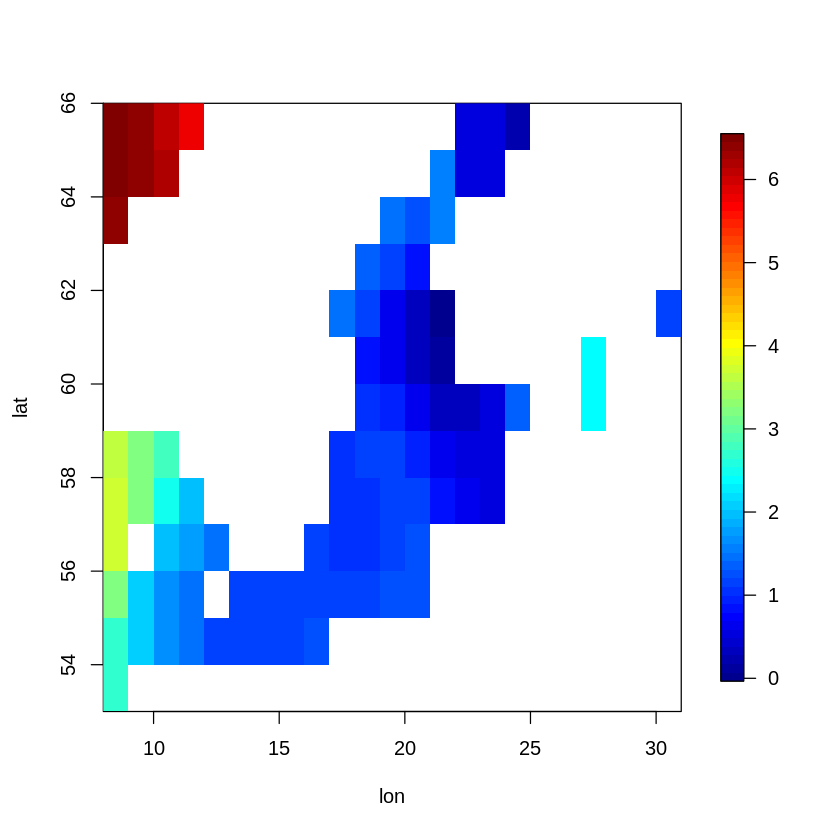

In [3]:
library(fields)
image.plot(lon,lat,sst[,,1])

We then convert the time axis to dates. For this purpose we read the "units" attribute of variable "TIME":

In [4]:
nc = open.nc("../Data/HadISST_Baltic.nc")
timeunits = att.get.nc(nc,"TIME","units")
close.nc(nc)
timeunits

[1] "days since 1870-01-01 00:00:00"

In [5]:
date = as.POSIXct(time*24*3600,origin="1870-01-01",tz="GMT")

To do an EOF analysis, we need a matrix (space-time) but we have a 3-d array (lat-lon-time). So let us first define a matrix where we put all spatial points in one column:

In [6]:
my_matrix = matrix(NA,nrow=length(lon)*length(lat),ncol=length(time))
dim(my_matrix)

[1]  299 1766

Now fill in the data:

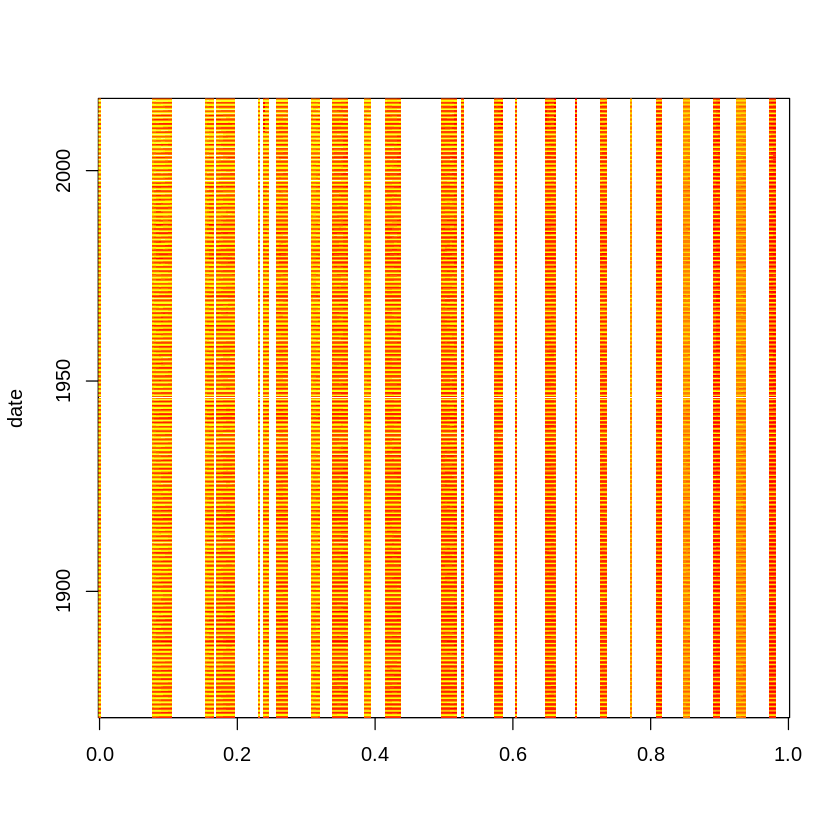

In [7]:
my_matrix[,] = sst[,,]
image(y=date,z=my_matrix)

We want to remove the land points now.

In [8]:
water_points = is.finite(sst[,,1])
water_points

TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE
FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE
FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE
FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE


In [9]:
# we select only water rows
reduced_matrix = my_matrix[water_points,]
dim(my_matrix)
dim(reduced_matrix)

[1]  299 1766

[1]   91 1766

Now we can do the EOF analysis by the R function **svd()** (singular value decomposition).

We can remove the mean first, it depends on what we want to explain by the EOF analysis: The temperature signal or its variation. Let's first keep the matrix as it is.

In [10]:
eof = svd(reduced_matrix)
summary(eof)

  Length Class  Mode   
d     91 -none- numeric
u   8281 -none- numeric
v 160706 -none- numeric

The output contains the following:
* Vector **d** contains the singular values
* The columns of **u** are the normalised spatial patterns
* The columns of **v** are the normalised temporal patterns

It is a matter of taste whether we multiply the scale $d_i$ to the spatial or temporal component. We will multiply it to the temporal component.

Let us first see the explained variance.

[1] 0.909114307 0.079935961 0.003434845 0.001824596 0.001199100

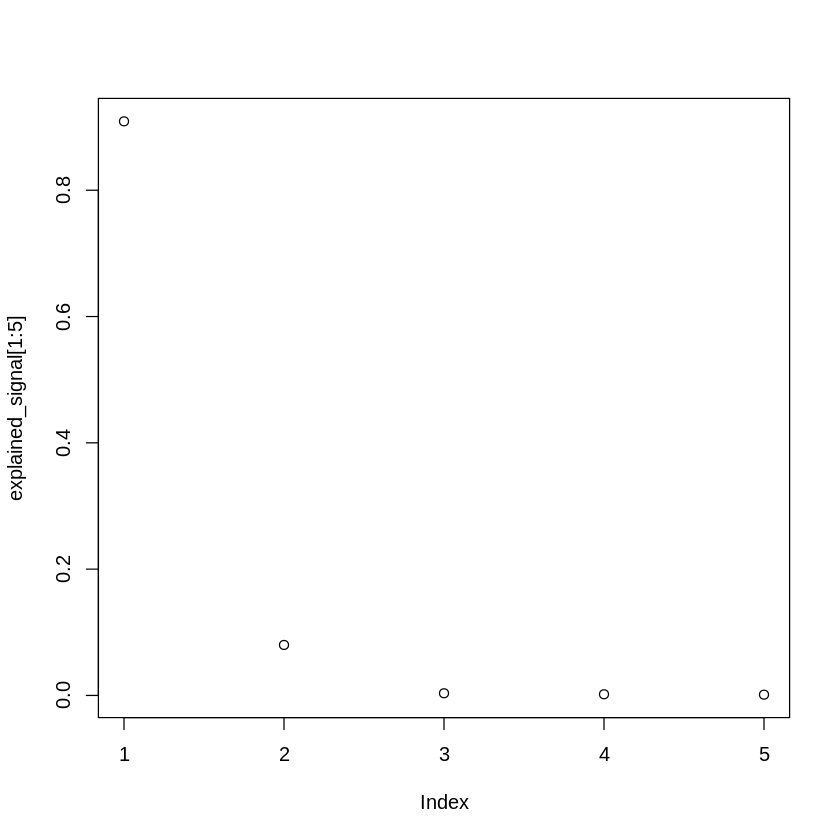

In [22]:
explained_signal = eof$d^2 / sum(eof$d^2)
explained_signal[1:5]
plot(explained_signal[1:5])

We see that only the first two EOFs play a role and explain 98% and 1.6% of the **squared temperature signal** (not the variance).

Let's plot the temporal component of EOF1.

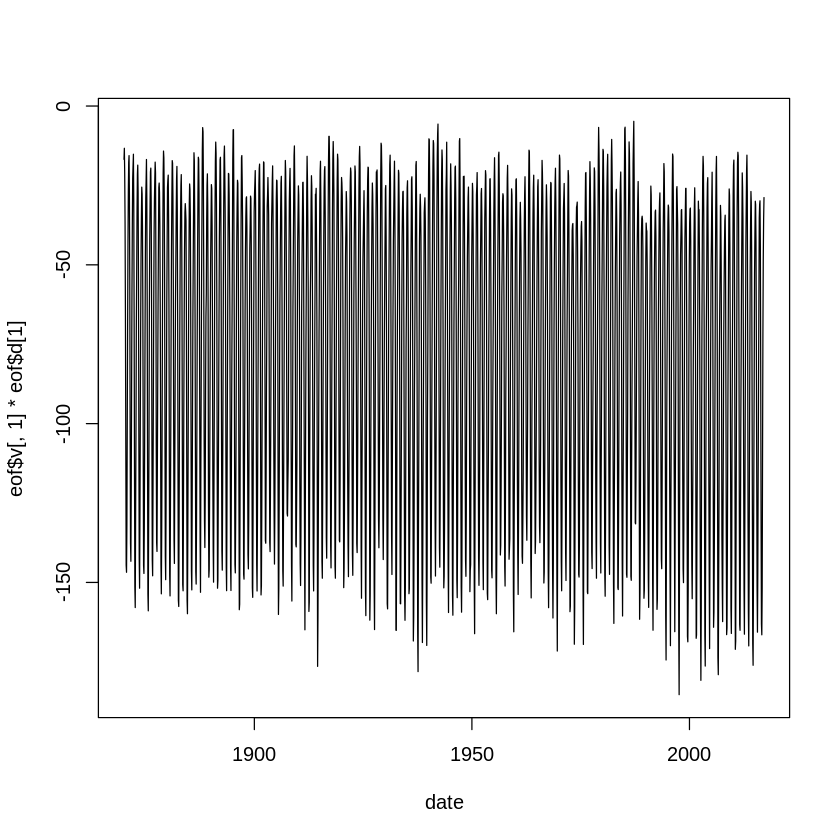

In [12]:
plot(date,eof$v[,1]*eof$d[1],type="l")

Looks something like a seasonal pattern, but all values are negative.

Remember that we can negate both the spatial and the temporal component and get the same result.

To plot the spatial pattern as well, we need to add the land points again.

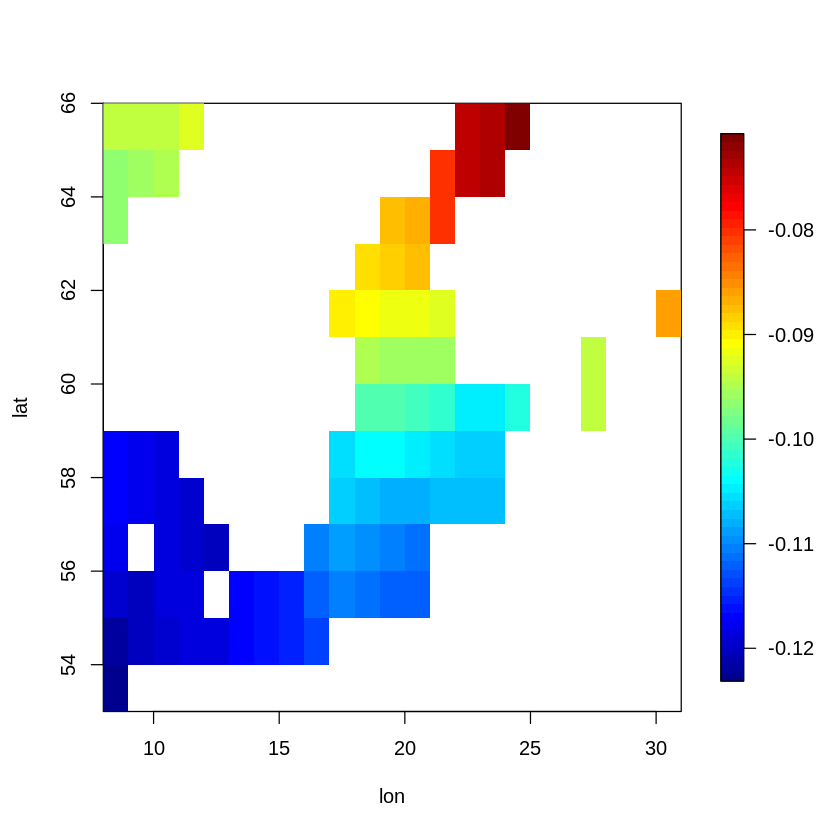

In [13]:
eof1 = matrix(NA,length(lon),length(lat))
eof1[water_points] = eof$u[,1]
image.plot(lon,lat,eof1)

The spatial values are also negative like the temporal ones, so it might make sense to multiply both of them by -1.

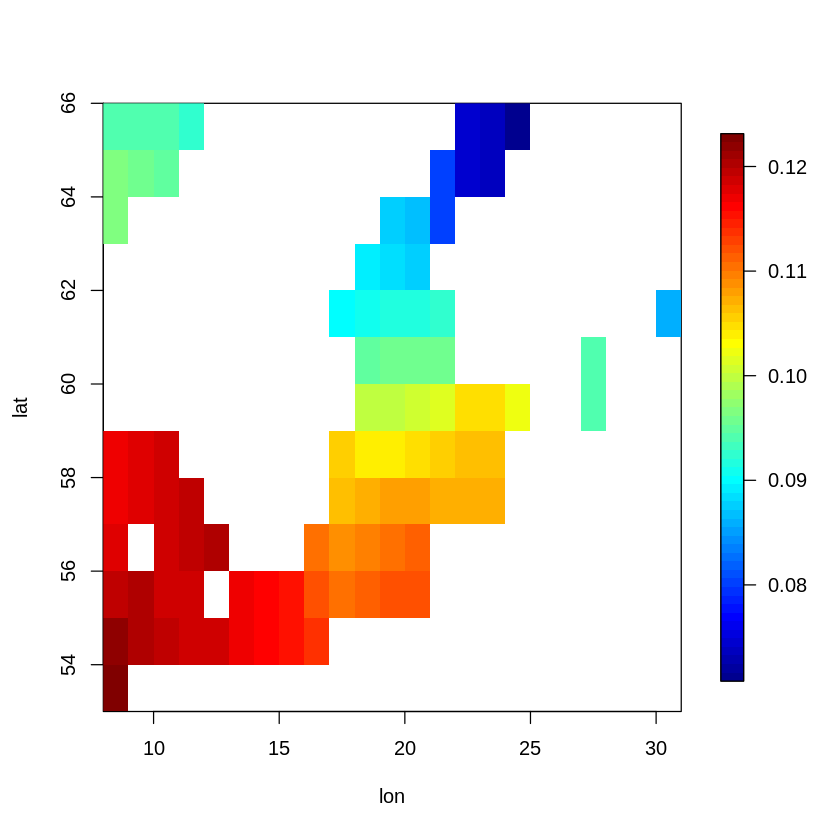

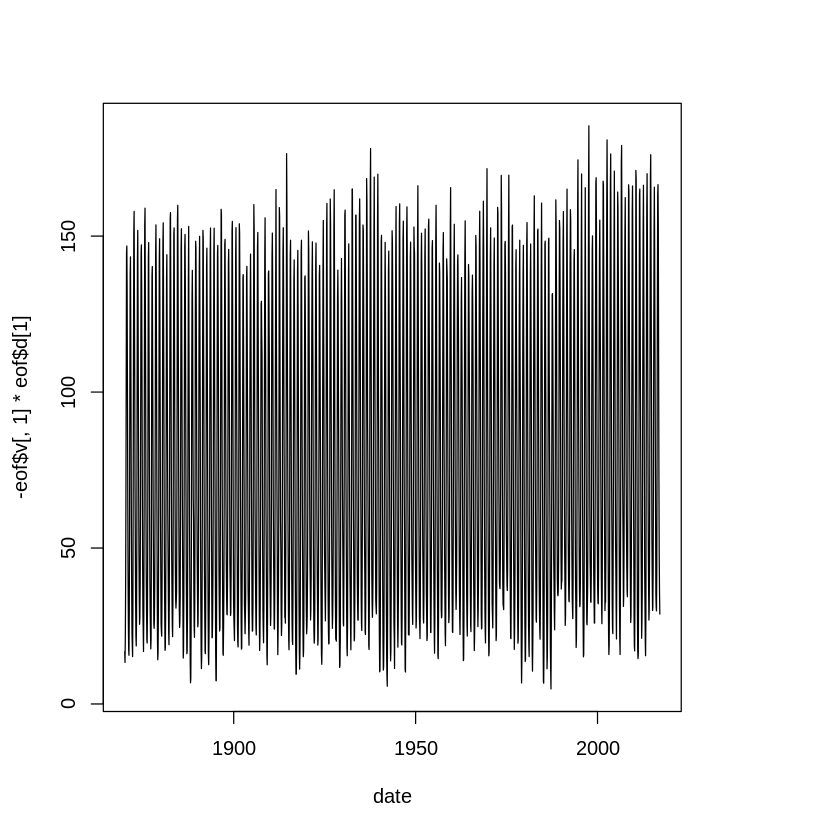

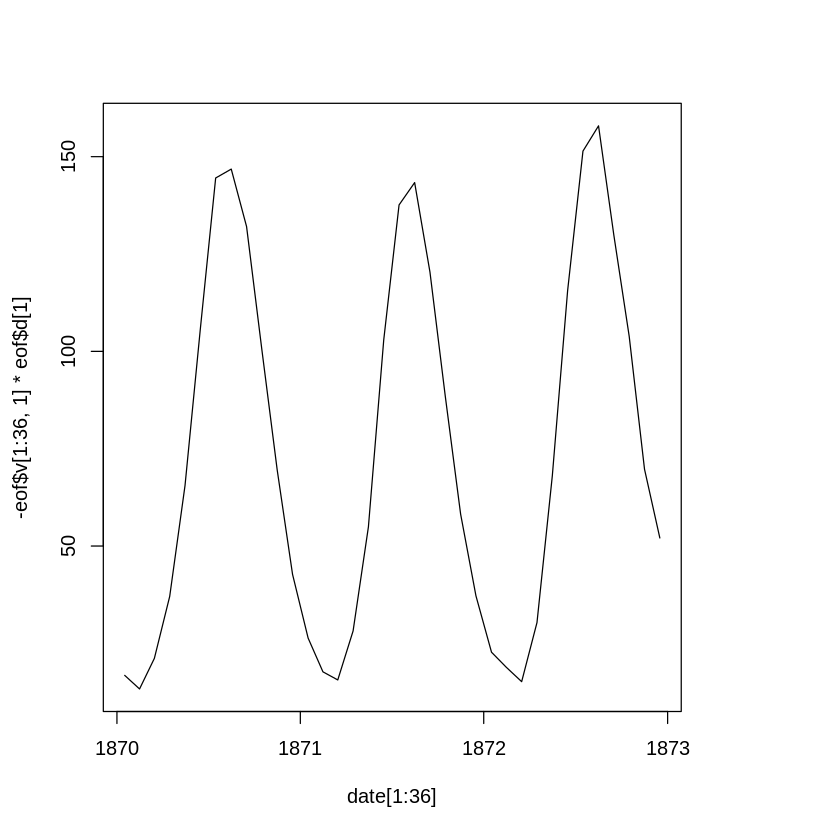

In [14]:
image.plot(lon,lat,-eof1)
plot(date,-eof$v[,1]*eof$d[1],type="l")
# zoom in to first three years
plot(date[1:36],-eof$v[1:36,1]*eof$d[1],type="l")

Now do the same for the second EOF:

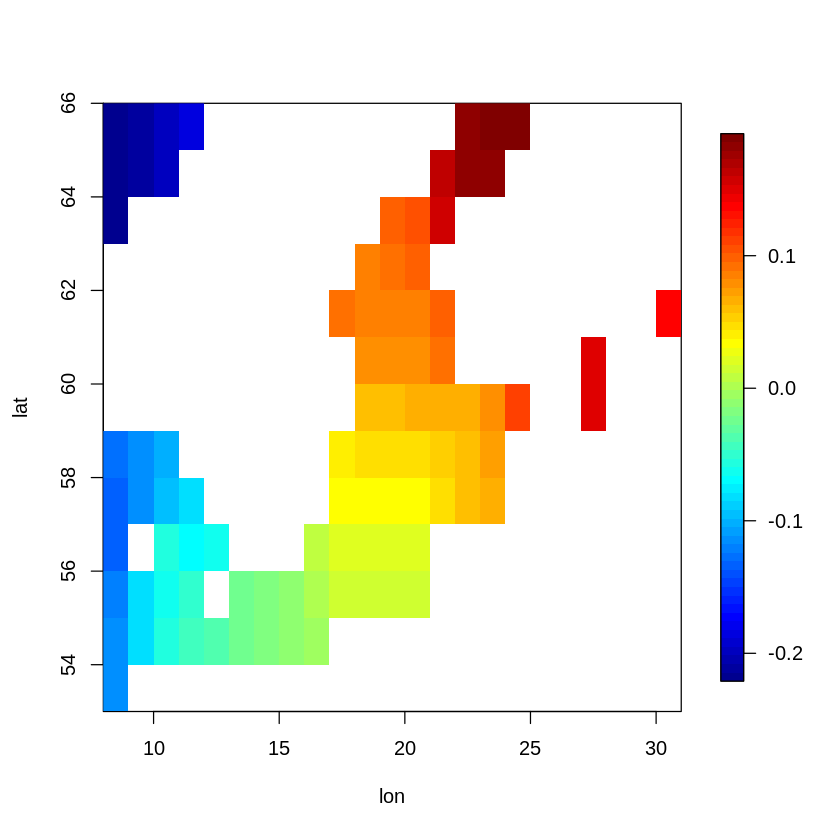

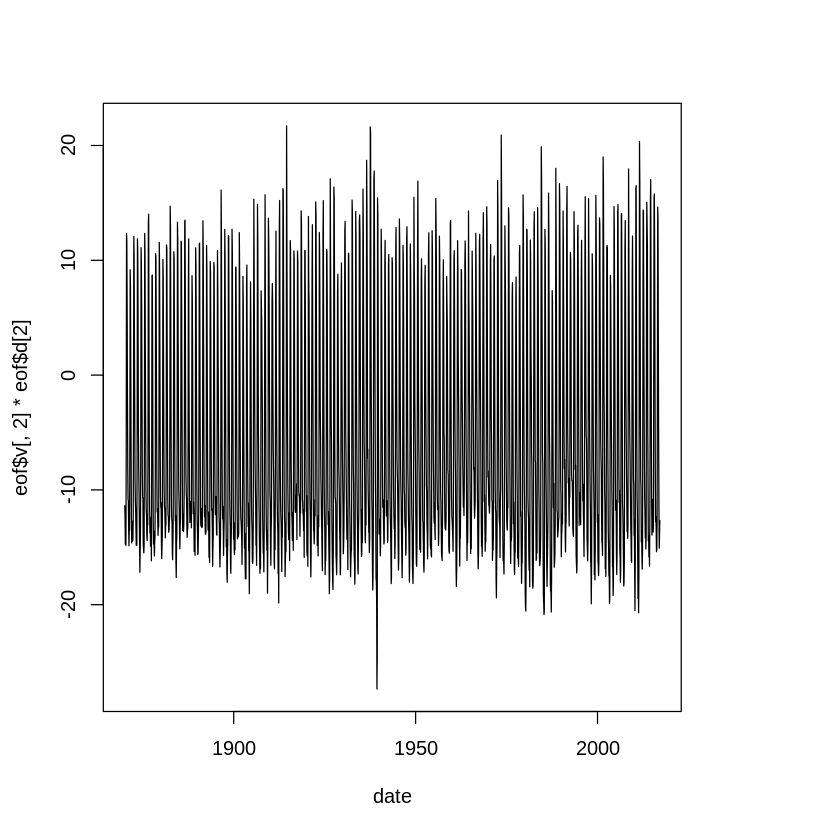

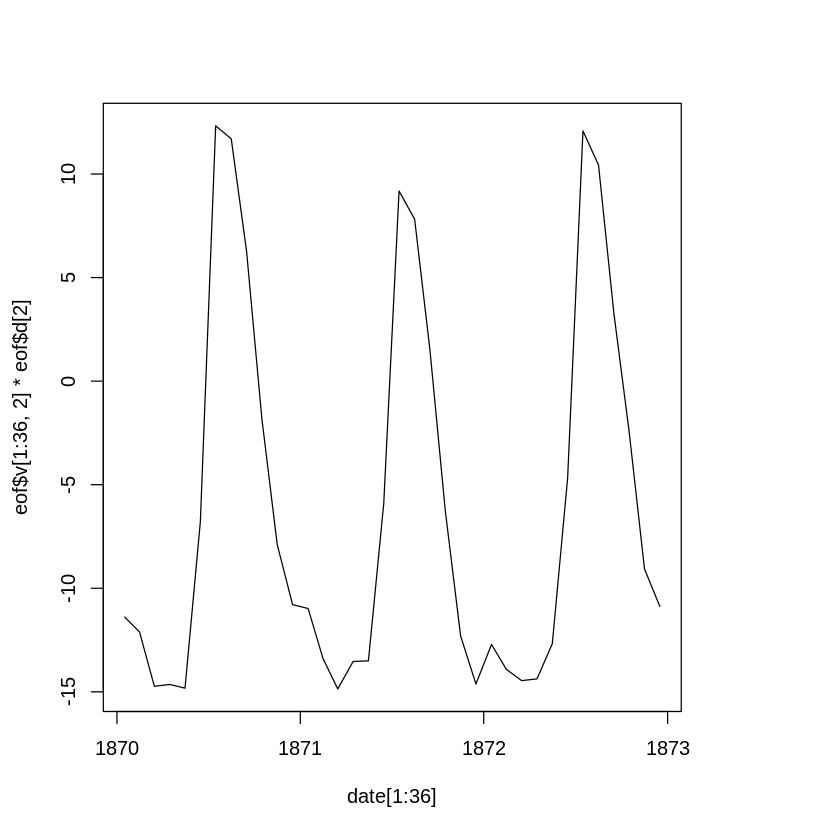

In [15]:
eof2 = matrix(NA,length(lon),length(lat))
eof2[water_points] = eof$u[,2]
image.plot(lon,lat,eof2)
plot(date,eof$v[,2]*eof$d[2],type="l")
# zoom in to first three years
plot(date[1:36],eof$v[1:36,2]*eof$d[2],type="l")

It is sometimes a good idea to scale the spatial EOF to have a maximum of 1, so you can more easily interpret the temporal EOF.

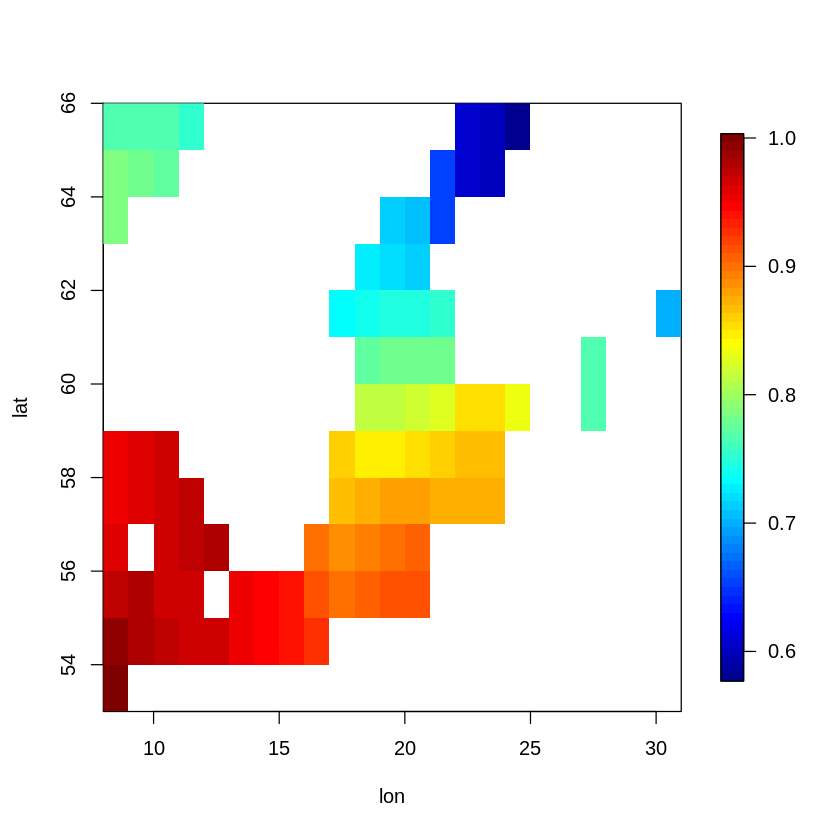

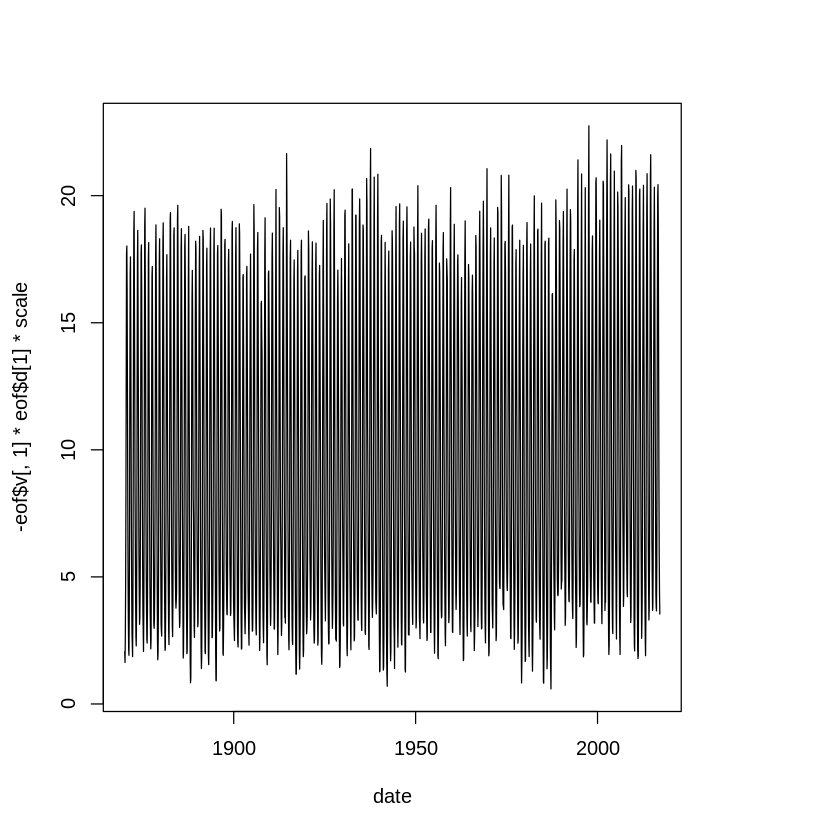

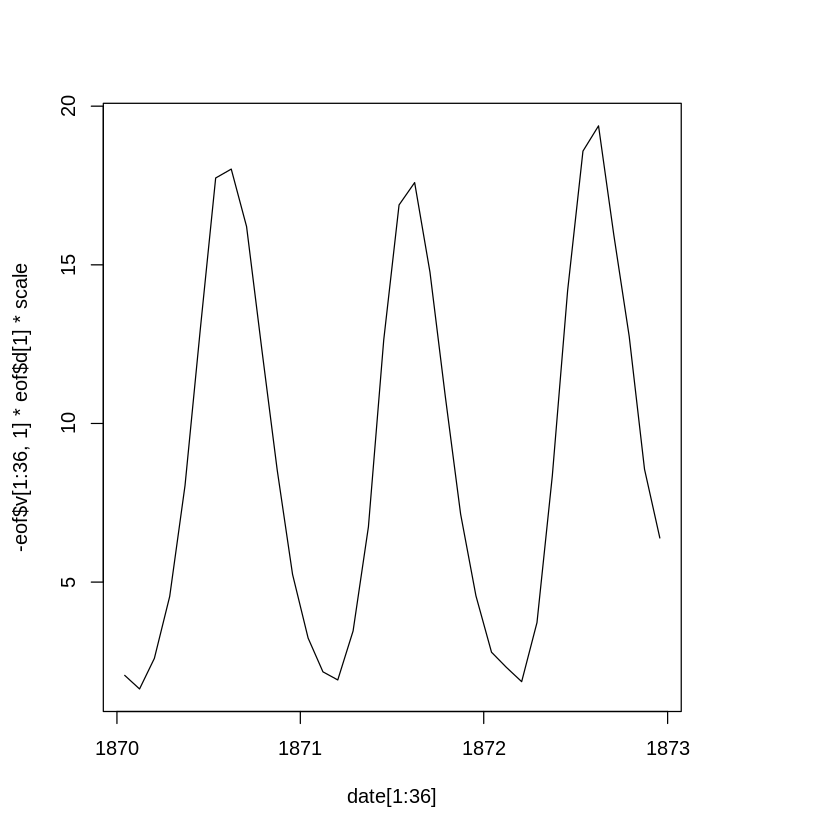

In [16]:
scale=max(abs(eof1),na.rm=TRUE)
image.plot(lon,lat,-eof1/scale)
plot(date,-eof$v[,1]*eof$d[1]*scale,type="l")
# zoom in to first three years
plot(date[1:36],-eof$v[1:36,1]*eof$d[1]*scale,type="l")

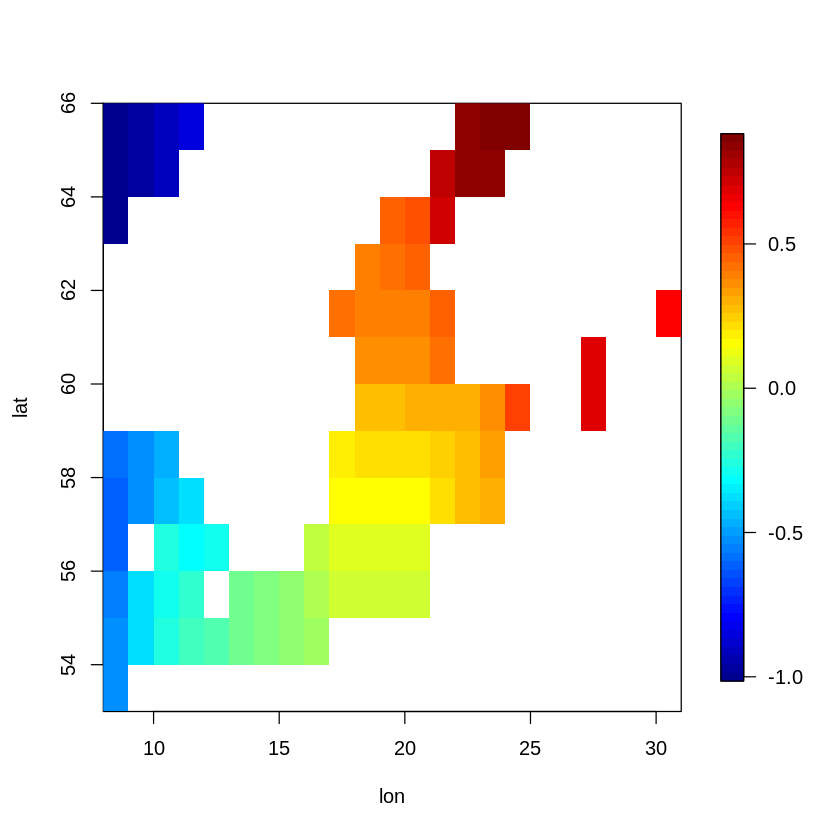

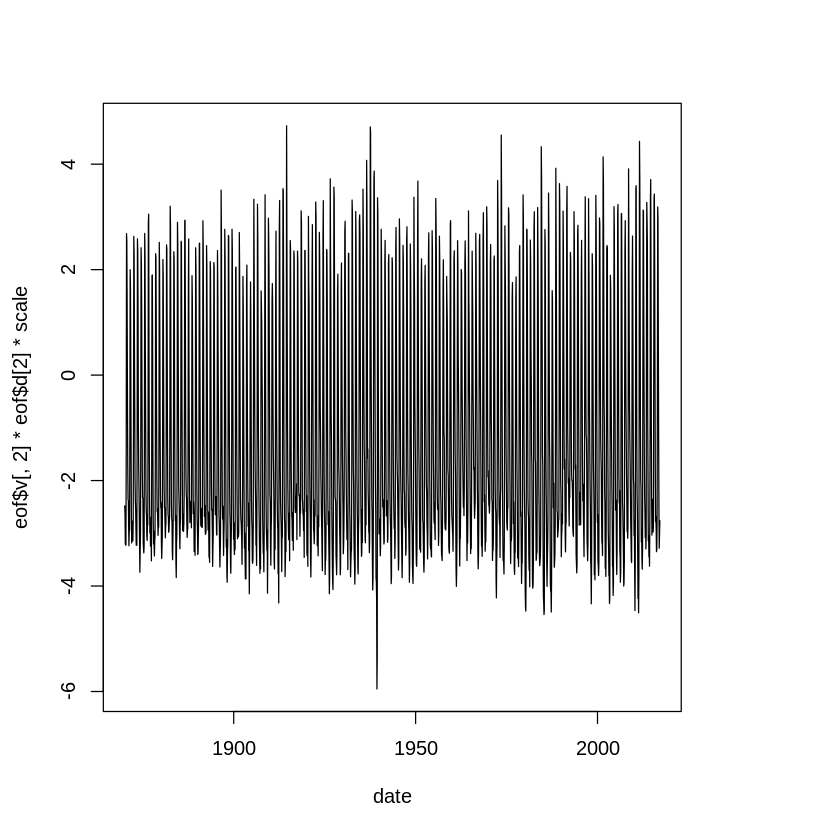

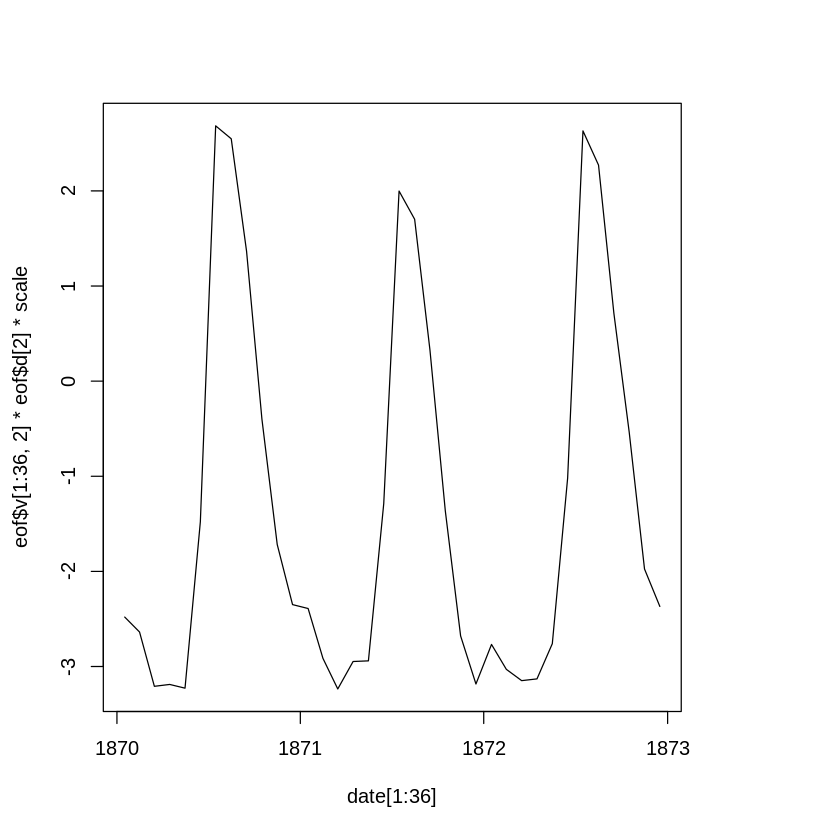

In [17]:
scale=max(abs(eof2),na.rm=TRUE)
image.plot(lon,lat,eof2/scale)
plot(date,eof$v[,2]*eof$d[2]*scale,type="l")
# zoom in to first three years
plot(date[1:36],eof$v[1:36,2]*eof$d[2]*scale,type="l")

Now we repeat the same but remove the mean first.

In [18]:
eof = svd(reduced_matrix-mean(reduced_matrix))
summary(eof)

  Length Class  Mode   
d     91 -none- numeric
u   8281 -none- numeric
v 160706 -none- numeric

We can then calculate explained variance:

In [19]:
explained_variance = eof$d^2 / sum(eof$d^2)
explained_variance[1:5]

[1] 0.909114307 0.079935961 0.003434845 0.001824596 0.001199100

Still, the first two EOFs explain the majority of the signal. We plot them again.

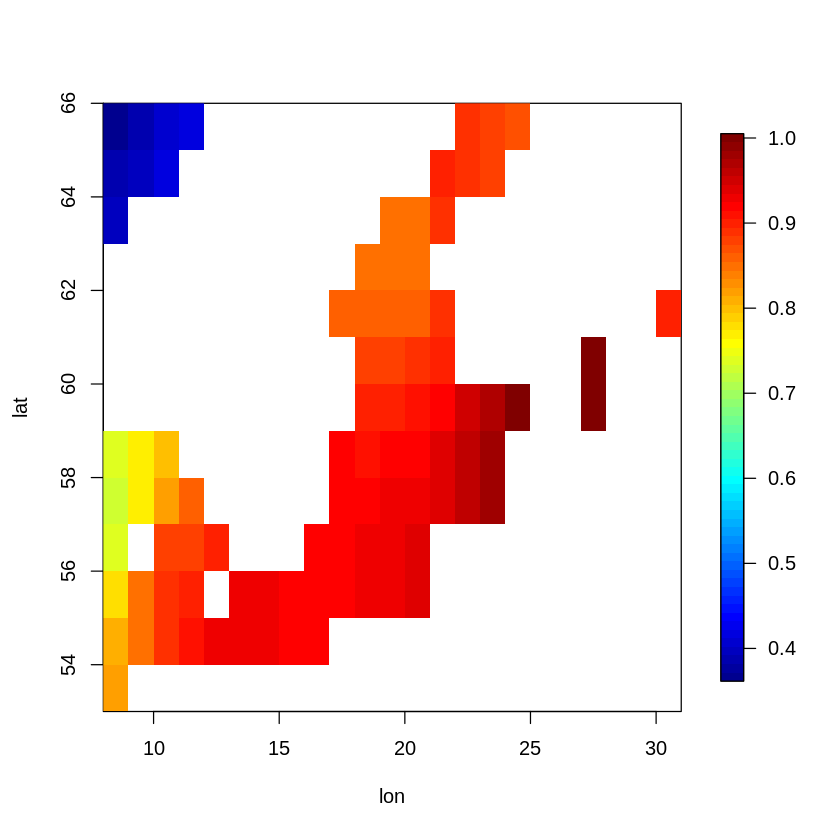

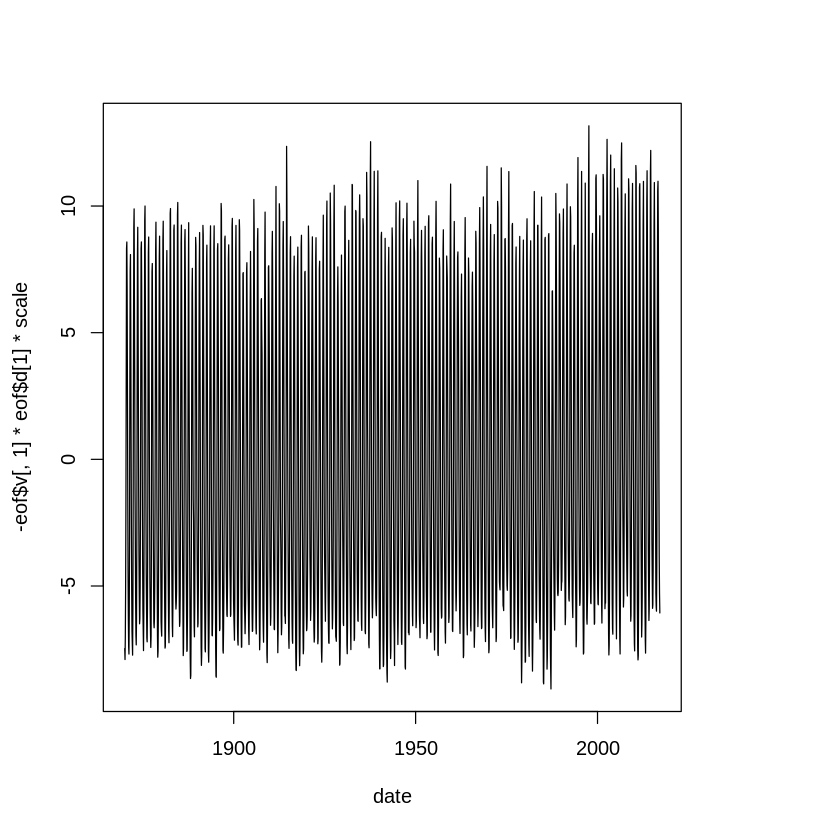

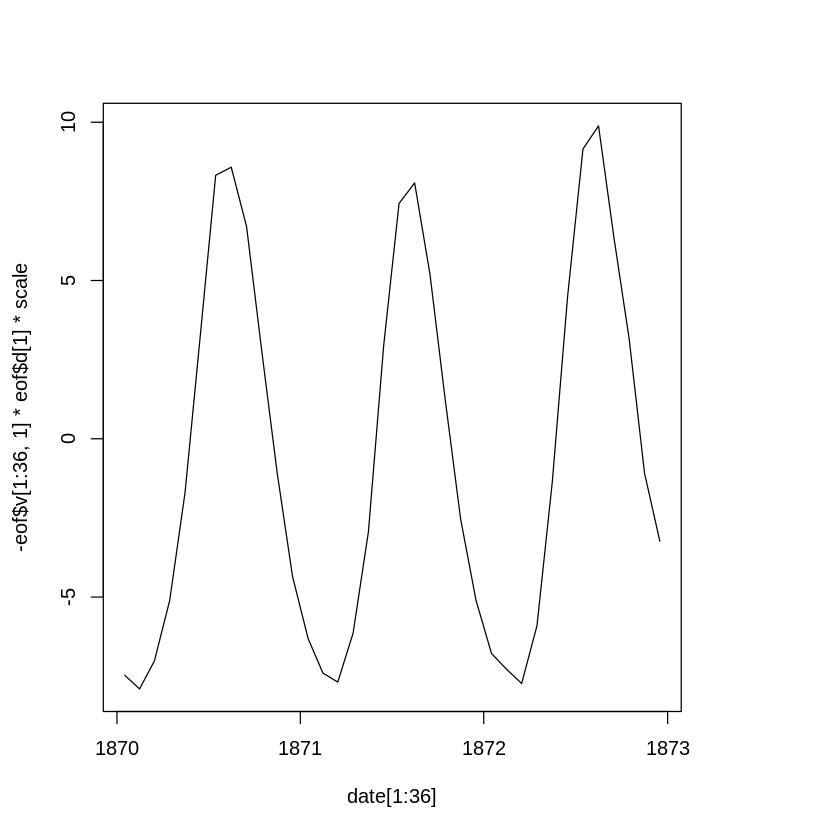

In [20]:
eof1 = matrix(NA,length(lon),length(lat))
eof1[water_points] = eof$u[,1]
scale=max(abs(eof1),na.rm=TRUE)
image.plot(lon,lat,-eof1/scale)
plot(date,-eof$v[,1]*eof$d[1]*scale,type="l")
# zoom in to first three years
plot(date[1:36],-eof$v[1:36,1]*eof$d[1]*scale,type="l")

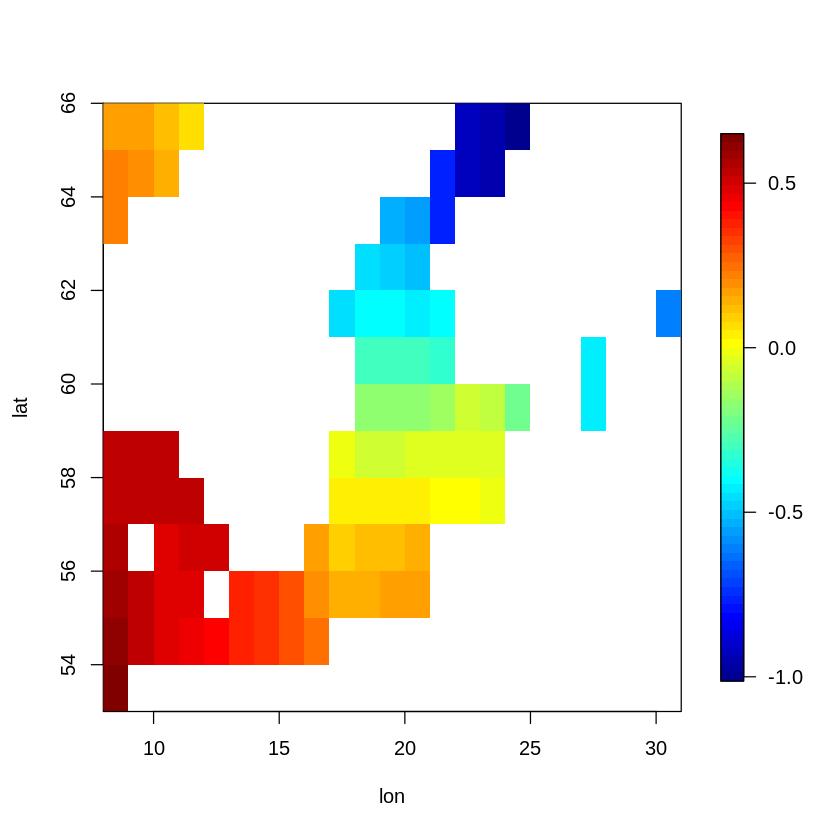

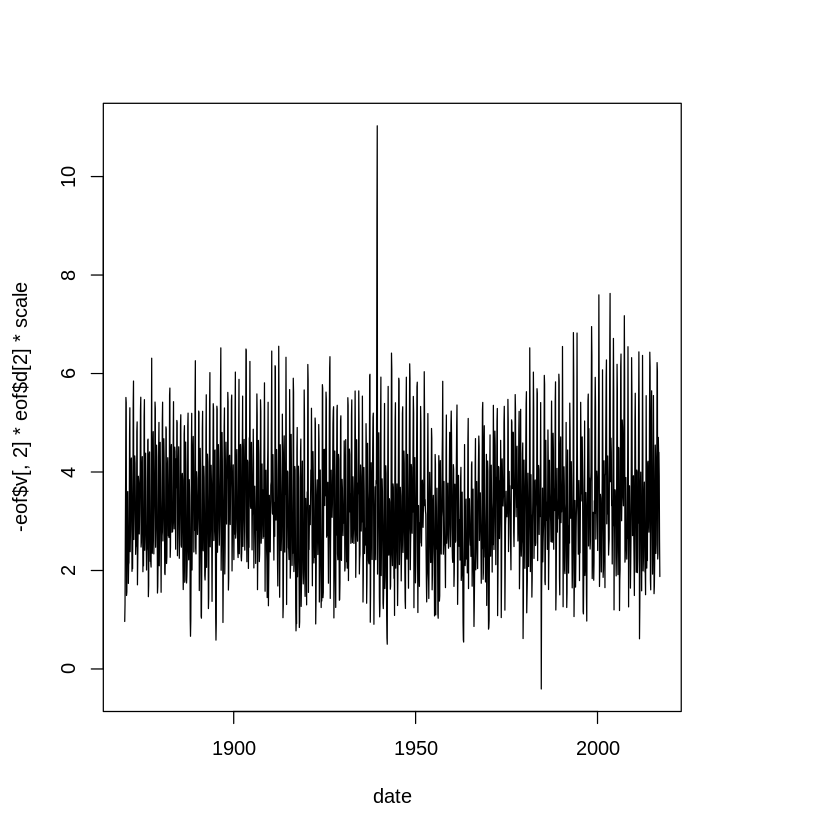

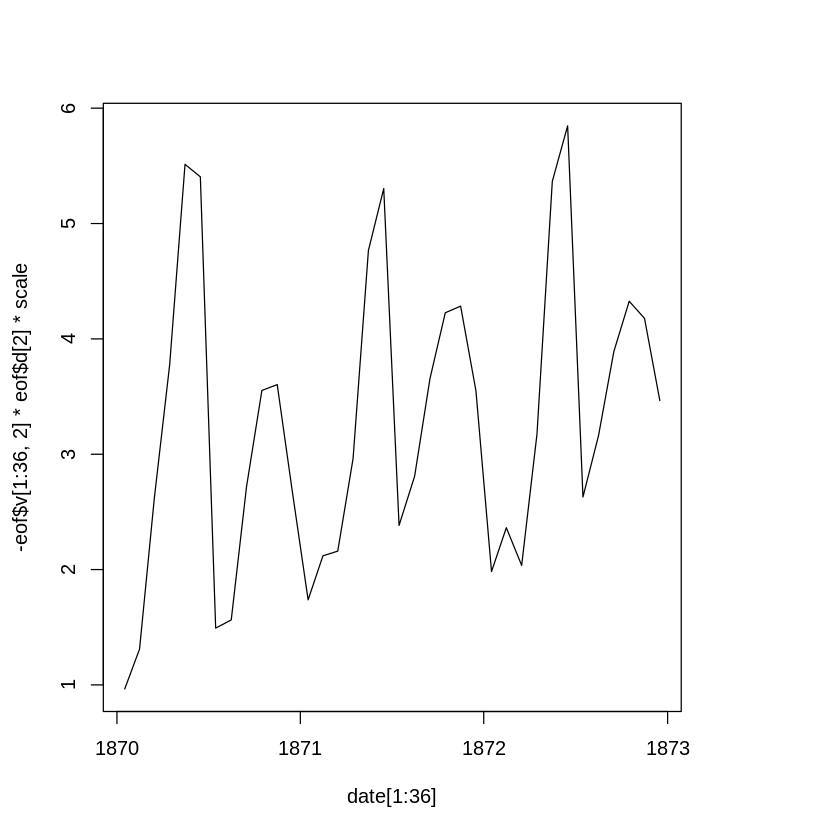

In [21]:
eof2 = matrix(NA,length(lon),length(lat))
eof2[water_points] = eof$u[,2]
scale=max(abs(eof2),na.rm=TRUE)
image.plot(lon,lat,-eof2/scale)
plot(date,-eof$v[,2]*eof$d[2]*scale,type="l")
# zoom in to first three years
plot(date[1:36],-eof$v[1:36,2]*eof$d[2]*scale,type="l")